In [1]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
orders = pd.read_csv("/home/metri/Desktop/DA/project/all/orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
prior = pd.read_csv('/home/metri/Desktop/DA/project/all/order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
train = pd.read_csv('/home/metri/Desktop/DA/project/all/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
products = pd.read_csv('/home/metri/Desktop/DA/project/all/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
aisles = pd.read_csv('/home/metri/Desktop/DA/project/all/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
departments = pd.read_csv('/home/metri/Desktop/DA/project/all/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Since the dataset is huge(32.4M rows), currently working on small portion(1M rows) of dataset to reduce the computations.

In [8]:
new_prior = prior[0:1000000]
print(new_prior.shape)
new_prior.head()

(1000000, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
final_df = pd.merge(new_prior,products, on = ['product_id','product_id'])
final_df = pd.merge(final_df,orders,on=['order_id','order_id'])
final_df = pd.merge(final_df,aisles,on=['aisle_id','aisle_id'])
final_df = pd.merge(final_df,departments, on=['department_id', 'department_id'])
print(final_df.shape)
final_df.head(10)

(1000000, 15)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs,dairy eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs,dairy eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs,dairy eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs,dairy eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs,dairy eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs,dairy eggs


## Quick Overview on products sold and uniqueness.

In [10]:
#The most sold product is banana followed by bag of organic bananas and so on
final_df['product_name'].value_counts()[0:5]

Banana                    14759
Bag of Organic Bananas    11867
Organic Strawberries       8138
Organic Baby Spinach       7477
Organic Hass Avocado       6551
Name: product_name, dtype: int64

In [11]:
#Top 5 aisles categories
final_df['aisle'].value_counts()[0:5]

fresh fruits                  112409
fresh vegetables              105047
packaged vegetables fruits     54781
yogurt                         44674
packaged cheese                30184
Name: aisle, dtype: int64

In [12]:
#Top 5 departments categories
final_df['department'].value_counts()[0:5]

produce       292208
dairy eggs    167077
snacks         89230
beverages      83125
frozen         68808
Name: department, dtype: int64

## Clustering 
Want to find a possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hence creating a dataframe with all the purchases made by each user

In [13]:
customer_prod = pd.crosstab(final_df['user_id'], final_df['department'])
print(customer_prod.shape)
customer_prod.head(10)

(67036, 21)


department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,2,0,0,0,2,1,0,...,0,0,1,0,0,0,0,0,4,1
10,0,0,0,0,0,0,1,7,8,0,...,0,1,9,0,0,17,0,0,31,1
13,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
19,0,0,0,1,0,0,3,2,0,0,...,0,1,1,0,0,8,0,0,2,1
21,3,0,1,3,1,0,0,4,0,0,...,0,1,0,0,0,1,0,0,8,5
23,0,0,1,1,0,0,0,4,0,0,...,1,0,0,0,0,0,1,0,1,0
27,0,0,0,8,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,1,2
32,0,1,0,2,0,0,0,7,1,0,...,0,0,1,0,0,1,0,0,4,1


Here we can see that there are approximately 67k unique users and 21 departments

# Model 1 --> Clustering by reducing the no of dimensions, i.e, PCA

In [14]:
#Model 1
#Fitting it into 2 components
pca = PCA(n_components=2)
pca.fit(customer_prod)
sample_pca = pca.transform(customer_prod)
reduced_df = pd.DataFrame(sample_pca)
reduced_df.head()

,0,1
0,-5.383340,-0.809699
1,-0.737027,-0.397451
2,27.711664,-7.400393
3,-4.810967,-0.313295
4,-1.366703,1.206270


In [15]:
tocluster = pd.DataFrame(reduced_df[[1,0]])
#print(tocluster.shape)
tocluster.head()

,1,0
0,-0.809699,-5.383340
1,-0.397451,-0.737027
2,-7.400393,27.711664
3,-0.313295,-4.810967
4,1.206270,-1.366703


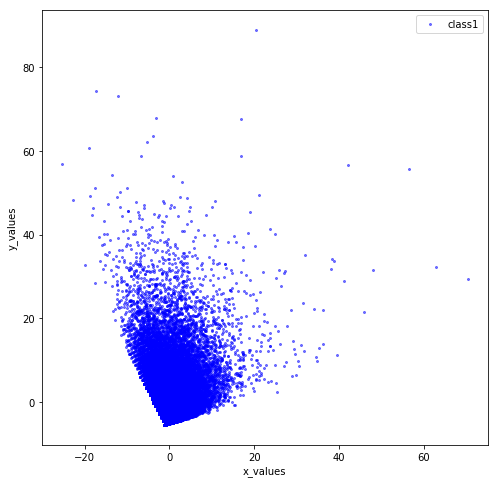

In [16]:
plt.figure(figsize=(8,8))
plt.plot(tocluster[1], tocluster[0], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [17]:
clusterer = KMeans(n_clusters=21,random_state=1).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)


In [18]:
#CLuster centers
centers

array([[-6.19295134e-01, -4.80585769e+00],
       [-1.25056085e-01,  5.07417636e+00],
       [-5.08637315e+00,  1.39344352e+01],
       [ 6.93303458e+00,  2.76522541e+01],
       [-4.06101088e+00,  7.31030963e+00],
       [-1.42797467e+00, -2.66715325e+00],
       [ 3.63444791e+00, -1.93232018e+00],
       [ 1.32782215e+01,  8.05801229e+00],
       [-2.87741045e+00,  2.73301176e+00],
       [-4.15571767e+00,  2.14158759e+01],
       [ 6.36609513e-01, -1.36322988e+00],
       [ 4.93878235e+00,  1.61077677e+01],
       [ 4.92074551e+00,  6.94425314e+00],
       [-6.64407234e+00,  3.23396406e+01],
       [ 7.00216408e+00,  1.26856808e+00],
       [ 2.98662949e+01,  2.16485215e+01],
       [ 1.78173159e+00,  1.78208394e+00],
       [-1.70001683e+00, -3.71752356e-02],
       [ 1.11971265e+00, -3.84719059e+00],
       [ 2.87220453e-02,  1.06280691e+01],
       [-3.95247509e+00,  4.93944465e+01]])

In [19]:
c_preds[0:200]

array([ 0, 10, 13,  0, 10,  1, 18,  6, 16,  0,  5, 18, 18, 17,  4,  5,  1,
        0,  0,  0, 17, 18,  1,  2, 10, 10,  0,  5, 14, 18,  9, 17,  0,  4,
        5,  4,  5,  0,  5, 10, 18,  0, 16,  1, 16, 14,  8,  6, 18,  8, 18,
       12,  0, 10,  0,  5, 18, 18,  6, 17, 16,  0, 17,  0,  6, 20,  0,  2,
        6,  0,  0, 14, 12, 17,  5, 10, 16, 12,  2, 18,  5, 16,  0, 17,  0,
        0, 18, 18, 17,  5,  6, 10,  0,  8, 15, 17, 18,  0, 17,  0,  5,  8,
       18,  5, 14, 18,  0,  7, 18,  0,  0, 17,  8, 14, 17, 17,  5, 18,  9,
        0, 10,  0,  6,  6, 17, 17, 10, 18,  6, 17,  5,  0, 12,  4,  0,  6,
       10,  0, 18,  0,  5, 18, 18,  0,  6, 16, 18, 16,  5,  7,  8, 17,  5,
        0,  0,  5, 19,  1, 18, 10, 16,  0, 18, 17, 17,  0, 17, 16,  0,  5,
       10,  0, 18, 16,  5,  4,  5, 18, 10,  4,  5,  5, 19,  5, 10,  0,  5,
        4,  4, 16,  5, 18, 18,  1,  1,  7,  5, 18,  6,  8], dtype=int32)

Here is how our clusters appear

In [20]:
cluster_segregation = customer_prod.copy()
cluster_segregation['cluster'] = c_preds
cluster_segregation.head(10)

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,2,0,0,0,2,1,0,...,0,1,0,0,0,0,0,4,1,10
10,0,0,0,0,0,0,1,7,8,0,...,1,9,0,0,17,0,0,31,1,13
13,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
19,0,0,0,1,0,0,3,2,0,0,...,1,1,0,0,8,0,0,2,1,10
21,3,0,1,3,1,0,0,4,0,0,...,1,0,0,0,1,0,0,8,5,1
23,0,0,1,1,0,0,0,4,0,0,...,0,0,0,0,0,1,0,1,0,18
27,0,0,0,8,0,0,0,4,0,0,...,0,0,0,0,0,0,0,1,2,6
32,0,1,0,2,0,0,0,7,1,0,...,0,1,0,0,1,0,0,4,1,16


We have formed the clusters based on departments, i.e, 21 departments. Now we can look into the clust_segregation crosstab for interesting pattern.

In [21]:
#No of customers in each cluster
cluster_count = []
cluster_names = []
for number in range(len(departments)):
    cluster_count.append(len(cluster_segregation[cluster_segregation['cluster']==number]))
    cluster_names.append('C'+str(number))

cluster_info = pd.DataFrame(cluster_count, cluster_names)
cluster_info.columns = ['Count']
cluster_info.transpose()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
Count,13592,2856,1010,254,2152,8566,3502,429,4243,539,...,700,1378,219,1448,64,3947,6645,8036,1401,66


### Top 5 departments for each cluster 

In [22]:
top_5 = []
colnames = []
for number in range(len(departments)):
    cluster = cluster_segregation[cluster_segregation['cluster']==number].drop('cluster',axis=1).mean()
    temp = cluster.sort_values(ascending=False)[0:5]
    top_5.append([temp.index[i] for i in range(5)])
    colnames.append('C'+str(number))
table = pd.DataFrame(top_5).transpose()
table.columns = colnames
table

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
0,beverages,produce,produce,produce,produce,produce,dairy eggs,dairy eggs,produce,produce,...,produce,dairy eggs,produce,dairy eggs,dairy eggs,produce,produce,dairy eggs,produce,produce
1,dairy eggs,dairy eggs,dairy eggs,dairy eggs,dairy eggs,dairy eggs,snacks,snacks,dairy eggs,dairy eggs,...,dairy eggs,produce,dairy eggs,snacks,snacks,dairy eggs,dairy eggs,beverages,dairy eggs,dairy eggs
2,produce,snacks,pantry,snacks,pantry,beverages,beverages,beverages,pantry,snacks,...,snacks,snacks,snacks,beverages,beverages,snacks,pantry,snacks,snacks,snacks
3,frozen,frozen,frozen,frozen,frozen,frozen,frozen,produce,frozen,pantry,...,frozen,beverages,pantry,produce,produce,beverages,frozen,frozen,frozen,pantry
4,snacks,beverages,snacks,beverages,snacks,pantry,produce,frozen,beverages,frozen,...,beverages,frozen,frozen,frozen,frozen,frozen,beverages,pantry,beverages,frozen


Analysis of the clusters confirm the initial hypothesis that the products from the departments mentioned below are most generically bought by majority of customers:

1. Produce
2. Dairy Eggs
3. Snacks
4. Beverages
5. Frozen and pantry
